In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import torch
from os.path import join
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
from circuit_toolkit.plot_utils import saveallforms

In [3]:
import sys 
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
from tensorboard_utils import extract_all_runs, extract_tensorboard_data_from_run, extract_last_step_summary
from training_run_analysis_utils import streaming_dataset_size_extract, sweep_collect_eval_data, extract_rule_list_from_eval_col, extract_rule_list_from_eval_col_Diffusion, format_rule_list_to_mat, visualize_train_heldout_rule, visualize_indiv_rule_dynam

from rule_new_utils import rule_table, relation_dict, attribute_dict, relation_dict_brief, rule_table_brief
from stats_plot_utils import add_rectangles

### Paths

In [4]:
tabdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Tables"
figdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Figures_newrule"

GPT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven"
DiT_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
SSM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/Mamba_raven"
EDM_exproot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"

In [5]:
figroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning"
GPTfigdir = join(figroot, "GPT2_raven")
EDMfigdir = join(figroot, "EDM_raven")
DiTfigdir = join(figroot, "DiT_raven")
SSMfigdir = join(figroot, "SSM_raven")

In [6]:
# Set the maximum column width to 100 characters
pd.set_option('display.max_colwidth', 100)

In [7]:
relation_dict_short = {k: v.replace("Progression","Prog.").replace("Arithmetic","Arith.").\
                            replace("pos ","+").replace("neg ","-").\
                            replace("pos","+").replace("neg","-")\
                                for k, v in relation_dict.items()}

In [8]:
def plot_rule_heatmap_matrix(plotmat, heldout_id=()):
    fig = plt.figure(figsize=(8, 6))
    sns.heatmap(plotmat, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
    add_rectangles(heldout_id, edgecolor="magenta", )
    plt.axis("image")
    plt.xticks(ticks=np.arange(10)+0.5, labels=[relation_dict_short[i] for i in range(10)], rotation=45, ha="right")
    plt.yticks(ticks=np.arange(4)+0.5, labels=[attribute_dict[i] for i in range(4)], rotation=0)
    return fig

In [9]:
figsyndir = r'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_PanelCompl_Accuracy'
os.makedirs(figsyndir, exist_ok=True)

In [10]:
syndf_GPT = pd.read_csv(join(tabdir, "GPT2_raven_tensorboard_data.csv"), index_col=0)
tb_data_col = pkl.load(open(join(tabdir, "GPT2_raven_tensorboard_raw_data.pkl"), "rb"))

In [11]:
syndf_GPT.index

Index(['GPT2_medium_uncond_heldout0_stream16M',
       'GPT2_medium_uncond_heldout0_stream1_6M',
       'GPT2_medium_uncond_heldout0_stream16M',
       'GPT2_medium_uncond_heldout0_stream0_16M', 'GPT2_medium_cond_all',
       'GPT2_small_uncond_heldout0_stream16M', 'GPT2_base_uncond_heldout0',
       'GPT2_base_uncond_heldout0_stream1_6M',
       'GPT2_medium_uncond_all_stream16M',
       'GPT2_medium_uncond_heldout0_stream16M',
       'GPT2_base_uncond_heldout0_stream0_16M',
       'GPT2_small_uncond_heldout0_stream0_016M',
       'GPT2_medium_uncond_heldout0_stream0_16M',
       'GPT2_base_uncond_heldout0_stream16M',
       'GPT2_base_uncond_heldout0_stream1_6M',
       'GPT2_small_uncond_heldout0_stream1_6M',
       'GPT2_base_uncond_heldout0_stream1_6M',
       'GPT2_small_uncond_heldout0_stream1_6M',
       'GPT2_medium_uncond_heldout0_stream0_016M',
       'GPT2_base_uncond_heldout0_stream16M',
       'GPT2_medium_uncond_heldout0_stream0_016M',
       'GPT2_base_uncond_heldout0_s

In [12]:
syndf_GPT.loc['GPT2_medium_uncond_heldout0_stream0_16M',:]

,Loss/train,Train/Avg_Loss,Val/AnyValid,Val/AnyValid_abinit,Val/Avg_Loss,Val/C2,Val/C2_abinit,Val/C3,Val/C3_abinit,lr,full_name,step,step/epoch
run_name,,,,,,,,,,,,,
GPT2_medium_uncond_heldout0_stream0_16M,0.507333,NaN,0.905000,0.504000,12.355254,0.3815,0.185,0.6185,0.1800,0.000074,GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240819-011524/tensorboard_logs,257499,254999
GPT2_medium_uncond_heldout0_stream0_16M,0.235797,0.625034,0.906167,0.616333,21.655064,0.3750,0.183,0.6250,0.3395,0.000000,GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240820-024019/tensorboard_logs,1000000,999999


In [13]:
expfullname = syndf_GPT.loc['GPT2_medium_uncond_heldout0_stream0_16M'].query("step > 900000").full_name[0]
print(expfullname)
expname = expfullname.split("/tensorboard_logs")[0]
prefix = "eval_step" if "stream" in expname else "eval_epoch"
eval_col = sweep_collect_eval_data(expname, GPT_exproot, prefix=prefix)
epoch_list, rule_list_all_cont, consistency_all_cont = extract_rule_list_from_eval_col(eval_col, is_abinit=True)
rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat = format_rule_list_to_mat(rule_list_all_cont, consistency_all_cont)
epoch_list, rule_list_all_cont_PC, consistency_all_cont_PC = extract_rule_list_from_eval_col(eval_col, is_abinit=False)
rule_cnt_mat_PC, cons3_rule_cnt_mat_PC, cons2_rule_cnt_mat_PC = format_rule_list_to_mat(rule_list_all_cont_PC, consistency_all_cont_PC)
eval_sample_num = rule_list_all_cont.shape[1]
if "heldout0" in expname:
    heldout_id = [1, 16, 20, 34, 37]  
else:
    heldout_id = []

/tmp/ipykernel_3892345/1205758197.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expfullname = syndf_GPT.loc['GPT2_medium_uncond_heldout0_stream0_16M'].query("step > 900000").full_name[0]


GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240820-024019/tensorboard_logs
Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven/GPT2_medium_RAVEN_uncond_heldout0_stream0_16M-20240820-024019/samples
example file: eval_step704999.pt


100%|██████████| 401/401 [00:48<00:00,  8.27it/s]


(401, 2000, 3) (401, 2, 2000)
(401, 2000, 3) (401, 2, 2000)


In [66]:
rule_cnt_mat_PC.shape

(401, 40)

In [15]:
heldout_mask = np.zeros(40, dtype=bool)
heldout_mask[heldout_id] = True

### Learning curve

In [53]:
figsyndir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_PanelCompl_Accuracy'

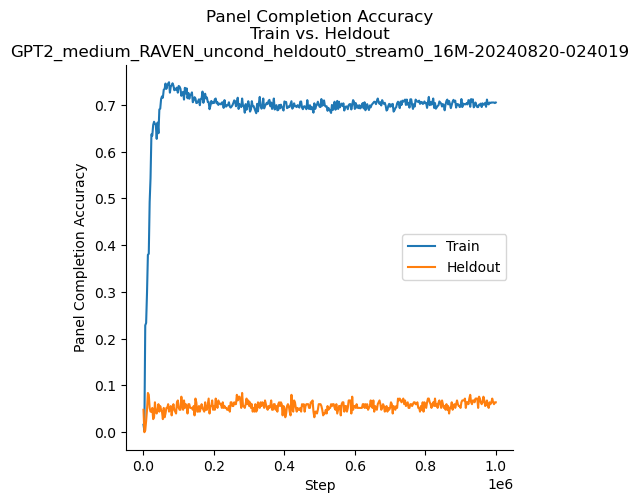

In [52]:
plt.figure(figsize=(5, 5))
plt.plot(epoch_list, cons3_rule_cnt_mat_PC[:, ~heldout_mask].mean(axis=1) / eval_sample_num * 40, label="Train")
plt.plot(epoch_list, cons3_rule_cnt_mat_PC[:, heldout_mask].mean(axis=1) / eval_sample_num * 40, label="Heldout")
plt.ylabel("Panel Completion Accuracy")
plt.xlabel("Step")
plt.legend()
plt.title(f"Panel Completion Accuracy\nTrain vs. Heldout\n{expname}")
saveallforms(figsyndir, f"panel_compl_acc_learning_curve_train_heldout_split_{expname}")

In [46]:
valid_tsr = np.array([len(elem)>0 for elem in rule_list_all_cont.flatten()]).reshape(rule_list_all_cont.shape)
C23_tsr = np.array([len(elem)>0 for elem in consistency_all_cont.flatten()]).reshape(consistency_all_cont.shape)
C2_tsr = C23_tsr[:, 1, :]
C3_tsr = C23_tsr[:, 0, :]

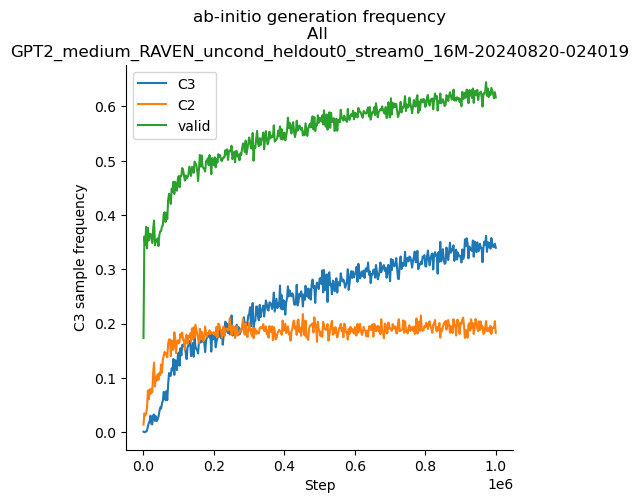

In [48]:
plt.figure(figsize=(5, 5))
plt.plot(epoch_list, C3_tsr.mean(axis=1), label="C3")
plt.plot(epoch_list, C2_tsr.mean(axis=1), label="C2")
plt.plot(epoch_list, valid_tsr.mean(axis=(1,2)), label="valid")
# plt.plot(epoch_list, cons3_rule_cnt_mat[:, heldout_mask].mean(axis=1) / eval_sample_num * 40, label="Heldout")
plt.title("ab-initio generation frequency")
plt.ylabel("C3 sample frequency")
plt.xlabel("Step")
plt.legend()
plt.title(f"ab-initio generation frequency\nAll \n{expname}")
saveallforms(figsyndir, f"abinit_gen_freq_C3_learning_curve_{expname}")

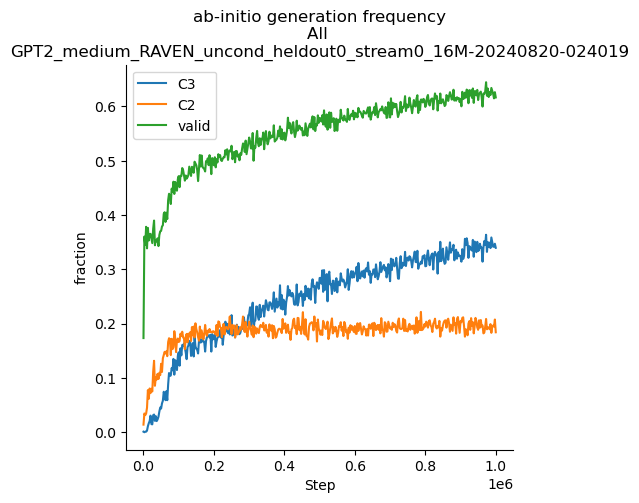

In [49]:
plt.figure(figsize=(5, 5))
plt.plot(epoch_list, cons3_rule_cnt_mat.sum(axis=1) / eval_sample_num, label="C3")
plt.plot(epoch_list, cons2_rule_cnt_mat.sum(axis=1) / eval_sample_num, label="C2")
plt.plot(epoch_list, valid_tsr.mean(axis=(1,2)), label="valid")
# plt.plot(epoch_list, cons3_rule_cnt_mat[:, heldout_mask].mean(axis=1) / eval_sample_num * 40, label="Heldout")
plt.title("ab-initio generation frequency")
plt.ylabel("fraction")
plt.xlabel("Step")
plt.legend()
plt.title(f"ab-initio generation frequency\nAll \n{expname}")
saveallforms(figsyndir, f"abinit_gen_freq_C3_learning_curve_{expname}")

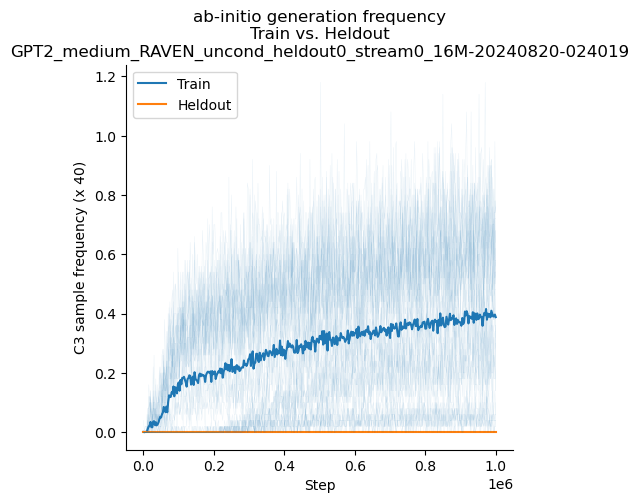

In [51]:
plt.figure(figsize=(5, 5))
plt.plot(epoch_list, cons3_rule_cnt_mat[:, ~heldout_mask].mean(axis=1) / eval_sample_num * 40, label="Train")
plt.plot(epoch_list, cons3_rule_cnt_mat[:, heldout_mask].mean(axis=1) / eval_sample_num * 40, label="Heldout")
plt.plot(epoch_list, cons3_rule_cnt_mat[:, ~heldout_mask] / eval_sample_num * 40, alpha=0.1, lw=0.3, color="C0")
plt.plot(epoch_list, cons3_rule_cnt_mat[:, heldout_mask] / eval_sample_num * 40, alpha=0.1, lw=0.3, color="C1")
plt.title("ab-initio generation frequency")
plt.ylabel("C3 sample frequency (x 40)")
plt.xlabel("Step")
plt.legend()
plt.title(f"ab-initio generation frequency\nTrain vs. Heldout\n{expname}")
saveallforms(figsyndir, f"abinit_gen_freq_learning_curve_train_heldout_split_{expname}")

### Heat maps

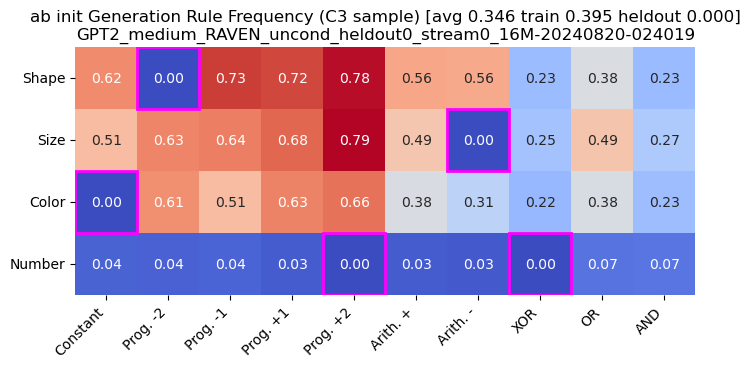

In [60]:
# plotinput = (accuracy_table[-5:,:].mean(axis=0))
plotmat = (cons3_rule_cnt_mat[-10:,:].mean(axis=0)).reshape(4, -1) / eval_sample_num * 40
plot_rule_heatmap_matrix(plotmat, heldout_id=heldout_id)
heldout_avg = plotmat.flatten()[heldout_mask].mean()
train_avg = plotmat.flatten()[~heldout_mask].mean()
plt.title(f"ab init Generation Rule Frequency (C3 sample) [avg {plotmat.mean():.3f} train {train_avg:.3f} heldout {heldout_avg:.3f}]\n{expname}")
saveallforms(figsyndir, f"{expname}_abinit_gen_acc_heatmap_C3sample", )

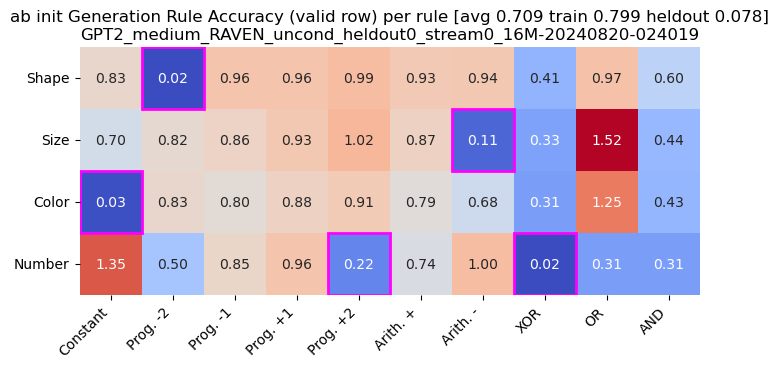

In [61]:
plotmat = (rule_cnt_mat[-10:,:].mean(axis=0)).reshape(4, -1) / eval_sample_num / 3 * 40 
plot_rule_heatmap_matrix(plotmat, heldout_id=heldout_id)
heldout_avg = plotmat.flatten()[heldout_mask].mean()
train_avg = plotmat.flatten()[~heldout_mask].mean()
plt.title(f"ab init Generation Rule Accuracy (valid row) per rule [avg {plotmat.mean():.3f} train {train_avg:.3f} heldout {heldout_avg:.3f}]\n{expname}")
saveallforms(figsyndir, f"{expname}_abinit_gen_acc_heatmap_validrow", )

In [67]:
epoch_num = rule_list_all_cont_PC.shape[0]
rule_num = 40
acc_cnt_table = np.zeros((epoch_num, rule_num))
accuracy_table = np.zeros((epoch_num, rule_num))
val_cnt_table = np.zeros((epoch_num, rule_num))
val_accuracy_table = np.zeros((epoch_num, rule_num))
mis_cnt_table = np.zeros((epoch_num, rule_num, rule_num))
for epochi in range(epoch_num):
    rule_list = rule_list_all_cont_PC[epochi]
    consistency_list = consistency_all_cont_PC[epochi]
    for rulei in range(rule_num):
        rule_mask = (rule_list[:,0]==np.array([rulei])) & (rule_list[:,1]==np.array([rulei]))
        C3_rules = consistency_list[0][rule_mask]
        C3_rules_flatten = sum(list(C3_rules), [])
        C3_cont_cnt = len(C3_rules_flatten)
        accuracy_table[epochi, rulei] = C3_cont_cnt / sum(rule_mask)
        acc_cnt_table[epochi, rulei] = C3_cont_cnt
        val_cnt_table[epochi, rulei] = sum(len(rule3) > 0 for rule3 in rule_list[rule_mask,-1])
        val_accuracy_table[epochi, rulei] = val_cnt_table[epochi, rulei] / sum(rule_mask)

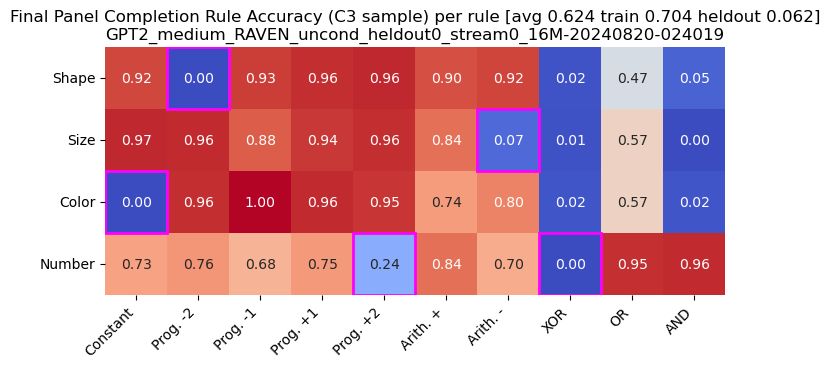

In [65]:
# plotinput = (accuracy_table[-5:,:].mean(axis=0))
plotmat = (cons3_rule_cnt_mat_PC[-10:,:].mean(axis=0)).reshape(4, -1) / eval_sample_num * 40
plt.figure(figsize=(8, 6))
sns.heatmap(plotmat, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
add_rectangles(heldout_id, edgecolor="magenta", )
plt.axis("image")
plt.xticks(ticks=np.arange(10)+0.5, labels=[relation_dict_short[i] for i in range(10)], rotation=45, ha="right")
plt.yticks(ticks=np.arange(4)+0.5, labels=[attribute_dict[i] for i in range(4)], rotation=0)
heldout_avg = plotmat.flatten()[heldout_mask].mean()
train_avg = plotmat.flatten()[~heldout_mask].mean()
plt.title(f"Final Panel Completion Rule Accuracy (C3 sample) per rule [avg {plotmat.mean():.3f} train {train_avg:.3f} heldout {heldout_avg:.3f}]\n{expname}")
saveallforms(figsyndir, f"{expname}_final_panel_compl_acc_heatmap_C3sample", )

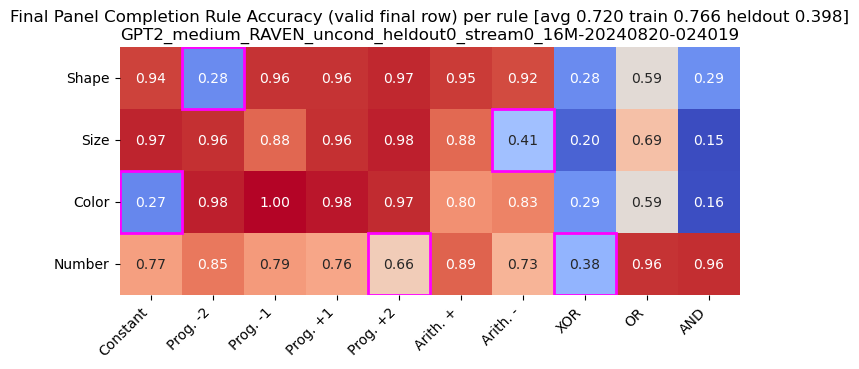

In [69]:
# plotinput = (accuracy_table[-5:,:].mean(axis=0))
# plotmat = (cons3_rule_cnt_mat_PC[-10:,:].mean(axis=0)).reshape(4, -1) / eval_sample_num * 40
plotmat = (val_accuracy_table[-10:,:].mean(axis=0)).reshape(4, -1)
plt.figure(figsize=(8, 6))
sns.heatmap(plotmat, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
add_rectangles(heldout_id, edgecolor="magenta", )
plt.axis("image")
heldout_avg = plotmat.flatten()[heldout_mask].mean()
train_avg = plotmat.flatten()[~heldout_mask].mean()
plt.title(f"Final Panel Completion Rule Accuracy (valid final row) per rule [avg {plotmat.mean():.3f} train {train_avg:.3f} heldout {heldout_avg:.3f}]\n{expname}")
plt.xticks(ticks=np.arange(10)+0.5, labels=[relation_dict_short[i] for i in range(10)], rotation=45, ha="right")
plt.yticks(ticks=np.arange(4)+0.5, labels=[attribute_dict[i] for i in range(4)], rotation=0)
saveallforms(figsyndir, f"{expname}_final_panel_compl_acc_heatmap_validrow", )

In [72]:
GPT_acc_vec = accuracy_table[-10:,:].mean(axis=0)
df_GPT_cplt = pd.DataFrame({"rule": range(40), "accuracy": GPT_acc_vec})
df_GPT_cplt.to_csv(join(figsyndir, f"GPT2_raven_panel_completion_accuracy_{expname}.csv"))

In [70]:
0.589 * 40 /35

0.6731428571428572

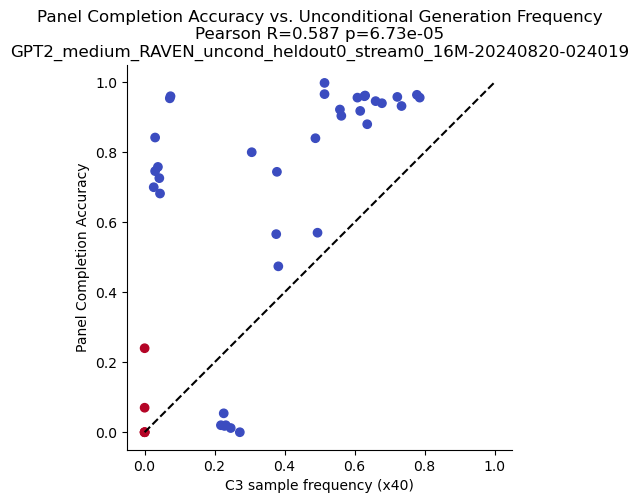

In [26]:
from scipy.stats import pearsonr, spearmanr
PC_acc_vec = (cons3_rule_cnt_mat_PC[-10:,:].mean(axis=0)) / eval_sample_num * 40
uncond_freq_vec = (cons3_rule_cnt_mat[-10:,:].mean(axis=0)) / eval_sample_num * 40
plt.figure(figsize=(5, 5))
plt.scatter(uncond_freq_vec, PC_acc_vec, c=heldout_mask, cmap="coolwarm")
# compute pearson correlation
rho, pval = pearsonr(PC_acc_vec, uncond_freq_vec)
plt.plot([0, 1], [0, 1], "k--")
plt.title(f"Panel Completion Accuracy vs. Unconditional Generation Frequency\nPearson R={rho:.3f} p={pval:.2e}\n{expname}")
plt.ylabel("Panel Completion Accuracy")
plt.xlabel("C3 sample frequency (x40)")
plt.axis("image")
# plt.legend()
saveallforms(figsyndir, f"panel_compl_acc_vs_uncond_freq_scatter_{expname}")
plt.show()

### Old experiments

In [101]:
expfullname = syndf_GPT.loc['GPT2_medium_uncond_heldout0'].full_name
print(expfullname)
expname = expfullname.split("/tensorboard_logs")[0]
prefix = "eval_step" if "stream" in expname else "eval_epoch"
eval_col = sweep_collect_eval_data(expname, GPT_exproot, prefix=prefix)
epoch_list, rule_list_all_cont, consistency_all_cont = extract_rule_list_from_eval_col(eval_col, is_abinit=True)
rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat = format_rule_list_to_mat(rule_list_all_cont, consistency_all_cont)
eval_sample_num = rule_list_all_cont.shape[1]
if "heldout0" in expname:
    heldout_id = [1, 16, 20, 34, 37]  
else:
    heldout_id = []

GPT2_medium_RAVEN_uncond_heldout0-20240701-133418/tensorboard_logs
Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven/GPT2_medium_RAVEN_uncond_heldout0-20240701-133418/samples
example file: eval_epoch9.pt


100%|██████████| 100/100 [00:10<00:00,  9.71it/s]


(100, 2048, 3) (100, 2, 2048)


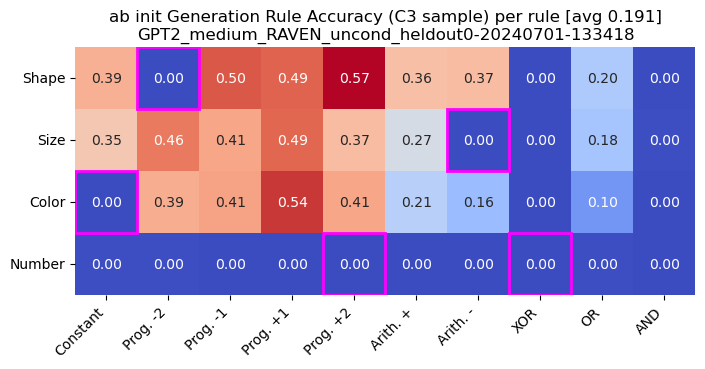

In [106]:
# plotinput = (accuracy_table[-5:,:].mean(axis=0))
plotmat = (cons3_rule_cnt_mat[-5:,:].mean(axis=0)).reshape(4, -1) / eval_sample_num * 40
plot_rule_heatmap_matrix(plotmat, heldout_id=heldout_id)
plt.title(f"ab init Generation Rule Accuracy (C3 sample) per rule [avg {plotmat.mean():.3f}]\n{expname}")
saveallforms(figsyndir, f"{expname}_abinit_gen_acc_heatmap_C3sample", )

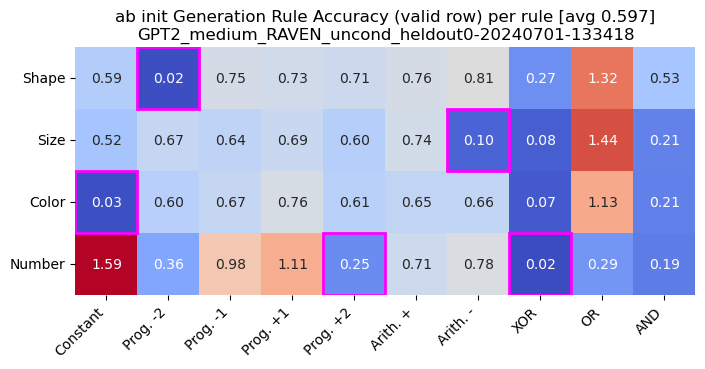

In [107]:
# plotinput = (accuracy_table[-5:,:].mean(axis=0))
plotmat = (rule_cnt_mat[-5:,:].mean(axis=0)).reshape(4, -1) / eval_sample_num / 3 * 40 
plot_rule_heatmap_matrix(plotmat, heldout_id=heldout_id)
plt.title(f"ab init Generation Rule Accuracy (valid row) per rule [avg {plotmat.mean():.3f}]\n{expname}")
saveallforms(figsyndir, f"{expname}_abinit_gen_acc_heatmap_validrow", )

In [10]:
expfullname = syndf_GPT.loc['GPT2_medium_uncond_heldout0'].full_name
print(expfullname)
expname = expfullname.split("/tensorboard_logs")[0]
prefix = "eval_step" if "stream" in expname else "eval_epoch"
eval_col = sweep_collect_eval_data(expname, GPT_exproot, prefix=prefix)
epoch_list, rule_list_all_cont, consistency_all_cont = extract_rule_list_from_eval_col(eval_col, is_abinit=False)
rule_cnt_mat, cons3_rule_cnt_mat, cons2_rule_cnt_mat = format_rule_list_to_mat(rule_list_all_cont, consistency_all_cont)
eval_sample_num = rule_list_all_cont.shape[1]

if "heldout0" in expname:
    heldout_id = [1, 16, 20, 34, 37]  
else:
    heldout_id = []

GPT2_medium_RAVEN_uncond_heldout0-20240701-133418/tensorboard_logs
Extracted data from /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/GPT2_raven/GPT2_medium_RAVEN_uncond_heldout0-20240701-133418/samples
example file: eval_epoch9.pt


100%|██████████| 100/100 [00:07<00:00, 13.57it/s]


(100, 2000, 3) (100, 2, 2000)


In [27]:
sum(len(rule3) > 0 for rule3 in rule_list[:,-1])

1475

In [28]:
epoch_num = rule_list_all_cont.shape[0]
rule_num = 40
acc_cnt_table = np.zeros((epoch_num, rule_num))
accuracy_table = np.zeros((epoch_num, rule_num))
val_cnt_table = np.zeros((epoch_num, rule_num))
val_accuracy_table = np.zeros((epoch_num, rule_num))
mis_cnt_table = np.zeros((epoch_num, rule_num, rule_num))
for epochi in range(epoch_num):
    rule_list = rule_list_all_cont[epochi]
    consistency_list = consistency_all_cont[epochi]
    for rulei in range(rule_num):
        rule_mask = (rule_list[:,0]==np.array([rulei])) & (rule_list[:,1]==np.array([rulei]))
        C3_rules = consistency_list[0][rule_mask]
        C3_rules_flatten = sum(list(C3_rules), [])
        C3_cont_cnt = len(C3_rules_flatten)
        accuracy_table[epochi, rulei] = C3_cont_cnt / sum(rule_mask)
        acc_cnt_table[epochi, rulei] = C3_cont_cnt
        val_cnt_table[epochi, rulei] = sum(len(rule3) > 0 for rule3 in rule_list[rule_mask,-1])
        val_accuracy_table[epochi, rulei] = val_cnt_table[epochi, rulei] / sum(rule_mask)

In [16]:
accuracy_table[-5:,:].mean(axis=0)

array([0.964, 0.   , 0.98 , 0.984, 0.972, 0.932, 0.876, 0.056, 0.572,
       0.076, 0.944, 0.912, 0.956, 0.956, 0.928, 0.82 , 0.02 , 0.   ,
       0.608, 0.096, 0.004, 0.96 , 0.996, 0.996, 0.988, 0.704, 0.724,
       0.02 , 0.464, 0.044, 0.724, 0.708, 0.564, 0.72 , 0.232, 0.824,
       0.76 , 0.02 , 0.984, 0.944])

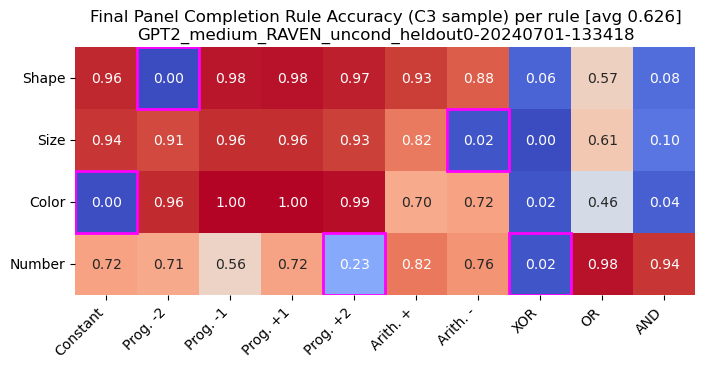

In [35]:
# plotinput = (accuracy_table[-5:,:].mean(axis=0))
plotmat = (accuracy_table[-5:,:].mean(axis=0)).reshape(4, -1)
plt.figure(figsize=(8, 6))
sns.heatmap(plotmat, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
add_rectangles(heldout_id, edgecolor="magenta", )
plt.axis("image")
plt.xticks(ticks=np.arange(10)+0.5, labels=[relation_dict_short[i] for i in range(10)], rotation=45, ha="right")
plt.yticks(ticks=np.arange(4)+0.5, labels=[attribute_dict[i] for i in range(4)], rotation=0)
plt.title(f"Final Panel Completion Rule Accuracy (C3 sample) per rule [avg {plotmat.mean():.3f}]\n{expname}")
saveallforms(figsyndir, f"{expname}_final_panel_compl_acc_heatmap_C3sample", )

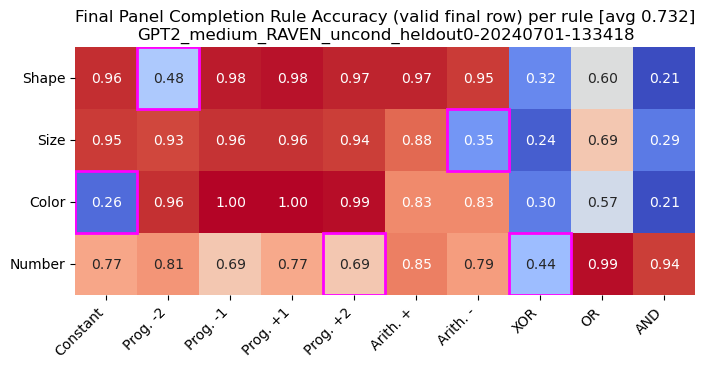

In [36]:
# plotinput = (accuracy_table[-5:,:].mean(axis=0))
plotmat = (val_accuracy_table[-5:,:].mean(axis=0)).reshape(4, -1)
plt.figure(figsize=(8, 6))
sns.heatmap(plotmat, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
add_rectangles(heldout_id, edgecolor="magenta", )
plt.axis("image")
plt.title(f"Final Panel Completion Rule Accuracy (valid final row) per rule [avg {plotmat.mean():.3f}]\n{expname}")
plt.xticks(ticks=np.arange(10)+0.5, labels=[relation_dict_short[i] for i in range(10)], rotation=45, ha="right")
plt.yticks(ticks=np.arange(4)+0.5, labels=[attribute_dict[i] for i in range(4)], rotation=0)
saveallforms(figsyndir, f"{expname}_final_panel_compl_acc_heatmap_validrow", )

In [83]:
GPT_acc_vec = accuracy_table[-5:,:].mean(axis=0)
df_GPT_cplt = pd.DataFrame({"rule": range(40), "accuracy": GPT_acc_vec})

### EDM & DiT

In [73]:
expname = "WideBlnrX3_new_RAVEN10_abstract_20240412-1347"
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"
DATASET = "RAVEN10_abstract"
expdir = join(exproot, expname)
EDM_inpaint_dir = join(expdir, "inpaint_pilot")
df_EDM_cplt = pd.read_csv(join(EDM_inpaint_dir, "inpaint_rule_stats.csv"))

<Figure size 1000x400 with 0 Axes>

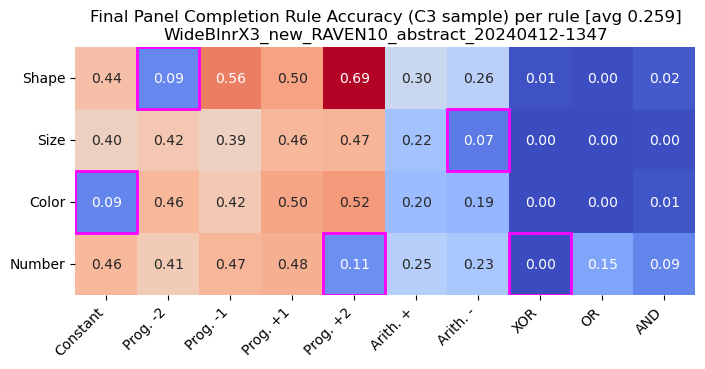

In [75]:
r3_per_class = df_EDM_cplt.groupby("iclass").agg({"consistent_r3": "mean"})
r3mat = r3_per_class.to_numpy().reshape(4,10) / 100
plt.figure(figsize=(10, 4))
figh = plot_rule_heatmap_matrix(r3mat, heldout_id=heldout_id)
plt.title(f"Final Panel Completion Rule Accuracy (C3 sample) per rule [avg {r3mat.mean():.3f}]\n{expname}")
saveallforms(figsyndir, f"{expname}_final_panel_compl_acc_heatmap_C3sample", )
# saveallforms(figdir, f"{expname}_inpaint_rule_consistency_per_class_heatmap", fmts=["png", "pdf"])

In [74]:
suffix = '_unif_baseline'
baseline_expname = "Uniform filling baseline"
df_rnd = pd.read_csv(join(EDM_inpaint_dir, f"inpaint_rule_stats{suffix}.csv"))

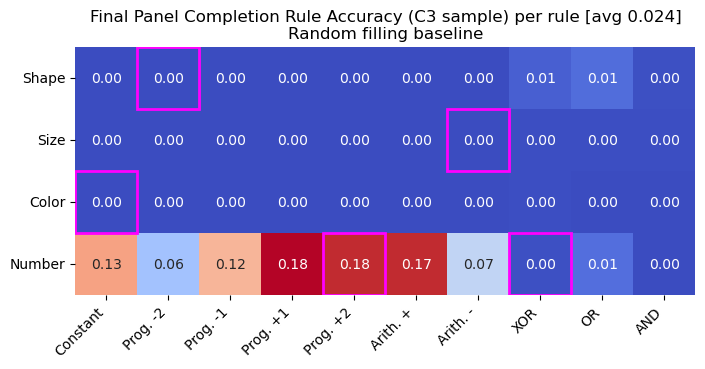

In [77]:
r3_per_class = df_rnd.groupby("iclass").agg({"consistent_r3": "mean"})
r3mat = r3_per_class.to_numpy().reshape(4,10) / 100
figh = plot_rule_heatmap_matrix(r3mat, heldout_id=heldout_id)
plt.title(f"Final Panel Completion Rule Accuracy (C3 sample) per rule [avg {r3mat.mean():.3f}]\n{'Random filling baseline'}")
saveallforms(figsyndir, f"{baseline_expname}_final_panel_compl_acc_heatmap_C3sample", )

In [75]:
DiTroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
DiTexpname = "045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256"
expdir = join(DiTroot, DiTexpname)
DiT_inpaint_dir = join(expdir, "inpaint_pilot")
df_DiT_cplt = pd.read_csv(join(DiT_inpaint_dir, "inpaint_rule_stats.csv"))

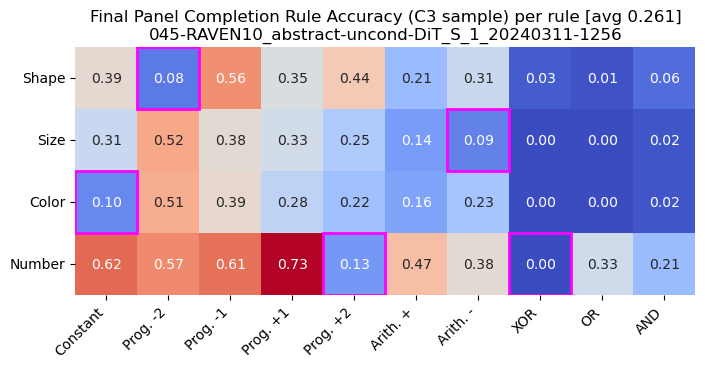

In [79]:
r3_per_class = df_DiT_cplt.groupby("iclass").agg({"consistent_r3": "mean"})
r3mat = r3_per_class.to_numpy().reshape(4,10) / 100
figh = plot_rule_heatmap_matrix(r3mat, heldout_id=heldout_id)
plt.title(f"Final Panel Completion Rule Accuracy (C3 sample) per rule [avg {r3mat.mean():.3f}]\n{DiTexpname}")
saveallforms(figsyndir, f"{DiTexpname}_final_panel_compl_acc_heatmap_C3sample", )

### New DiT Twisted sampling

In [79]:
!ls {DiTroot}/090*/inpainting_results/

inpainting_C3_acc_rule_heatmap_ep1000000_50_100_batch25.pdf
inpainting_C3_acc_rule_heatmap_ep1000000_50_100_batch25.png
inpainting_C3_acc_rule_heatmap_ep1000000_coolwarm.pdf
inpainting_C3_acc_rule_heatmap_ep1000000_coolwarm.png
inpainting_C3_acc_rule_heatmap_ep100000_50_100_batch25.pdf
inpainting_C3_acc_rule_heatmap_ep100000_50_100_batch25.png
inpainting_C3_acc_rule_heatmap_ep200000_50_100_batch25.pdf
inpainting_C3_acc_rule_heatmap_ep200000_50_100_batch25.png
inpainting_C3_acc_rule_heatmap_ep20000_50_100_batch25.pdf
inpainting_C3_acc_rule_heatmap_ep20000_50_100_batch25.png
inpainting_C3_acc_rule_heatmap_ep500000_50_100_batch25.pdf
inpainting_C3_acc_rule_heatmap_ep500000_50_100_batch25.png
inpainting_C3_acc_rule_heatmap_ep700000_50_100_batch25.pdf
inpainting_C3_acc_rule_heatmap_ep700000_50_100_batch25.png
inpainting_C3_acc_rule_heatmap_ep900000_50_100_batch25_coolwarm.pdf
inpainting_C3_acc_rule_heatmap_ep900000_50_100_batch25_coolwarm.png
inpainting_C3_acc_rule_heatmap_ep900000_50_100_b

In [80]:
DiTroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
DiTexpname = "090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204"
expdir = join(DiTroot, DiTexpname)
DiT_inpaint_dir = join(expdir, "inpainting_results")
df_DiT_TDS_cplt = pd.read_csv(join(DiT_inpaint_dir, "inpaint_stats_ep1000000_50_100_batch25.csv"))

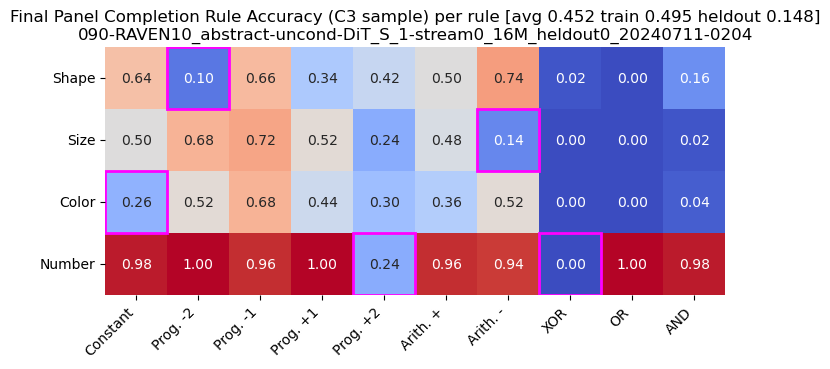

In [85]:
C3_per_class = df_DiT_TDS_cplt.groupby("rule_id").agg({"inpaint_acc": "mean"})
C3mat = C3_per_class.to_numpy().reshape(4,10) #/ 100
figh = plot_rule_heatmap_matrix(C3mat, heldout_id=heldout_id)
train_avg = C3mat.flatten()[~heldout_mask].mean()
heldout_avg = C3mat.flatten()[heldout_mask].mean()
plt.title(f"Final Panel Completion Rule Accuracy (C3 sample) per rule [avg {C3mat.mean():.3f} train {train_avg:.3f} heldout {heldout_avg:.3f}]\n{DiTexpname}")
saveallforms(figsyndir, f"{DiTexpname}_TDS_final_panel_compl_acc_heatmap_C3sample", )

### Synopsis

In [86]:
r3_per_class_GPT = pd.DataFrame({"consistent_r3": GPT_acc_vec})
# rename the index as "iclass"
r3_per_class_GPT.index = r3_per_class.index

In [96]:
r3_per_class_DiT_TDS

,inpaint_acc,Train,model
rule_id,,,
0,0.64,True,DiT-S/1 | TDS
1,0.10,False,DiT-S/1 | TDS
2,0.66,True,DiT-S/1 | TDS
3,0.34,True,DiT-S/1 | TDS
4,0.42,True,DiT-S/1 | TDS
5,0.50,True,DiT-S/1 | TDS
6,0.74,True,DiT-S/1 | TDS
7,0.02,True,DiT-S/1 | TDS
8,0.00,True,DiT-S/1 | TDS


In [97]:
train_msk = np.ones(40, dtype=bool)
train_msk[heldout_id] = False
r3_per_class_DiT_TDS = df_DiT_TDS_cplt.groupby("rule_id").agg({"inpaint_acc": "mean"}) 
r3_per_class_DiT = df_DiT_cplt.groupby("iclass").agg({"consistent_r3": "mean"}) / 100
r3_per_class_EDM = df_EDM_cplt.groupby("iclass").agg({"consistent_r3": "mean"}) / 100
r3_per_class_rnd = df_rnd.groupby("iclass").agg({"consistent_r3": "mean"}) / 100 # 40 classes array 
r3_per_class_DiT_TDS["Train"] = train_msk
r3_per_class_DiT_TDS["model"] = "DiT-S/1 | TDS"
r3_per_class_DiT_TDS.rename(columns={"inpaint_acc": "consistent_r3"}, inplace=True)
r3_per_class_DiT["Train"] = train_msk
r3_per_class_DiT["model"] = "DiT-S/1 | Repaint"
r3_per_class_EDM["Train"] = train_msk
r3_per_class_EDM["model"] = "EDMx2 | Repaint"
r3_per_class_rnd["Train"] = train_msk
r3_per_class_rnd["model"] = "Random"
r3_per_class_GPT["Train"] = train_msk
r3_per_class_GPT["model"] = "GPT2-M"
r3_per_class_cmb = pd.concat([r3_per_class_GPT, r3_per_class_DiT_TDS, r3_per_class_DiT, r3_per_class_EDM, r3_per_class_rnd], axis=0)
# reset index
r3_per_class_cmb.reset_index(inplace=True)

/tmp/ipykernel_2751824/4277899392.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=r3_per_class_cmb, x="Train", y="consistent_r3", hue="model",


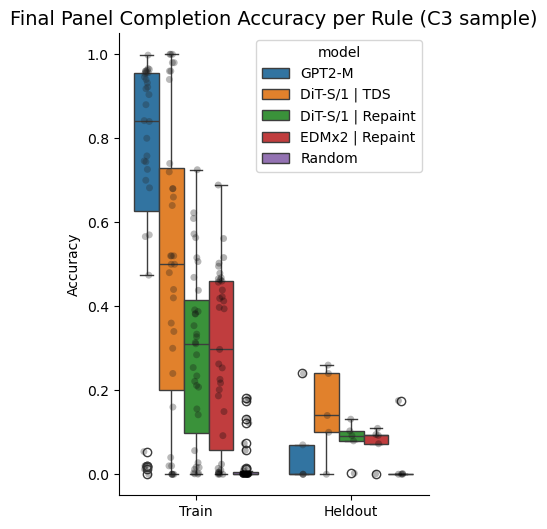

In [105]:
figh = plt.figure(figsize=(4, 6))
sns.boxplot(data=r3_per_class_cmb, x="Train", y="consistent_r3", hue="model", linewidth=1, order=[True, False],) # color="white", 
sns.stripplot(data=r3_per_class_cmb, x="Train", y="consistent_r3", hue="model", 
              dodge=True, jitter=True, marker='o', color='black', alpha=0.3, order=[True, False], legend=False)
plt.title(f"Final Panel Completion Accuracy per Rule (C3 sample)", fontsize=14)
plt.ylabel("Accuracy")
plt.xticks([0, 1], ["Train", "Heldout", ])
plt.xlabel("")
saveallforms(figsyndir, "AllModel_panel_completion_C3sample_acc_synopsis_new_strip", figh, ["png", "pdf"])
plt.show()

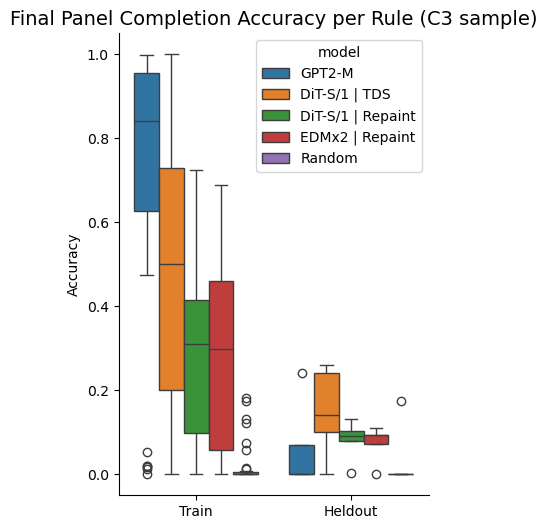

In [104]:
figh = plt.figure(figsize=(4, 6))
sns.boxplot(data=r3_per_class_cmb, x="Train", y="consistent_r3", hue="model", linewidth=1, order=[True, False],) # color="white", 
plt.title(f"Final Panel Completion Accuracy per Rule (C3 sample)", fontsize=14)
plt.ylabel("Accuracy")
plt.xticks([0, 1], ["Train", "Heldout", ])
plt.xlabel("")
saveallforms(figsyndir, "AllModel_panel_completion_C3sample_acc_synopsis_new", figh, ["png", "pdf"])
plt.show()

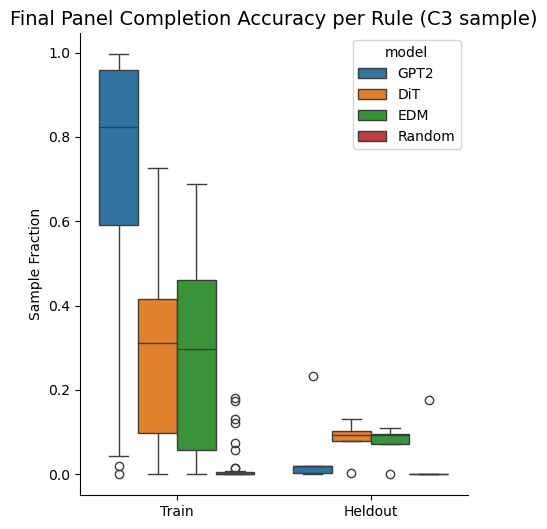

In [100]:
figh = plt.figure(figsize=(5, 6))
sns.boxplot(data=r3_per_class_cmb, x="Train", y="consistent_r3", hue="model", linewidth=1, order=[True, False],) # color="white", 
plt.title(f"Final Panel Completion Accuracy per Rule (C3 sample)", fontsize=14)
plt.ylabel("Sample Fraction")
plt.xticks([0, 1], ["Train", "Heldout", ])
plt.xlabel("")
saveallforms(figsyndir, "AllModel_panel_completion_C3sample_acc_synopsis", figh, ["png", "pdf"])
plt.show()